# Lokalizacja punktu w przestrzeni planarnej za pomocą metody trapezowej

### Konfiguracja narzędzia do wizualizacji algorytmu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.5

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

## Potrzebne klasy i struktury danych

In [3]:
%matplotlib notebook

def count_ab(segment):
    if segment.end.x - segment.start.x == 0:
        return 0, 0
    return ((segment.end.y - segment.start.y) / (segment.end.x - segment.start.x),
            segment.start.y - segment.start.x * ((segment.end.y - segment.start.y) / (segment.end.x - segment.start.x)))


def count_y(segment, x):
    a, b = count_ab(segment)
    return a * x + b

class Point:
    def __init__(self, point):
        self.x = point[0]
        self.y = point[1]
    
    def draw(self):
        return [self.x, self.y]
    
    def __str__(self):
        return f'({self.x},{self.y})'

class Segment:
    def __init__(self, segment):
        self.segment = segment
        if segment[0][0] < segment[1][0]:
            self.start = Point(segment[0])
            self.end = Point(segment[1])
        else:
            self.start = Point(segment[1])
            self.end = Point(segment[0])
    
    def draw(self):
        return [self.start.draw(), self.end.draw()]
    
    def __str__(self):
        return f'[{str(self.start)}, {str(self.end)}]'
    
    
class Trapezoid:
    def __init__(self, leftp, rightp, top, bottom, left_top = None, left_bottom = None, right_bottom = None, right_top = None):
        self.leftp = leftp
        self.rightp = rightp
        self.top = top
        self.bottom = bottom
        self.left_top = left_top
        self.left_bottom = left_bottom
        self.right_bottom = right_bottom
        self.right_top = right_top
        self.node = None
        
    def draw(self):
        res = []
        res.append((self.leftp.x, count_y(self.bottom, self.leftp.x)))
        res.append((self.rightp.x, count_y(self.bottom, self.rightp.x)))
        res.append((self.rightp.x, count_y(self.top, self.rightp.x)))
        res.append((self.leftp.x, count_y(self.top, self.leftp.x)))
        res.append(res[0])
        return [[[res[i][0], res[i][1]], [res[i + 1][0], res[i + 1][1]]] for i in range(len(res)-1)]

WALL = 0
X_NODE = 1
Y_NODE = 2

def det(a,b,c):
    return a.x*b.y + a.y*c.x + b.x*c.y - b.y*c.x - a.y*b.x - a.x*c.y

def is_above_segment(point, segment, eps=1e-6):
    orient = det(segment.start, segment.end, point)
    return orient > eps


class Node:
    def __init__(self, type, value, left = None, right = None, parent = None):
        if type == WALL:
            value.node = self
        self.type = type
        self.value = value
        self.left = left
        self.right = right
        self.parent = parent
    
    def connect_left(self, node):
        self.left = node
        node.parent = self
    
    def connect_right(self, node):
        self.right = node
        node.parent = self
    
class Graph:
    def __init__(self, starting_node = None):
        self.starting_node = starting_node
    
    def find(self, point_to_find, scenes = [], segments = []):
        if scenes:
            return self._find(point_to_find, self.starting_node, scenes, segments)
        return self._find(point_to_find, self.starting_node)
    
    def _find(self, point_to_find, current_node, scenes = [], segments = []):
        if current_node is None: return -1
        if current_node.type == WALL:
            if scenes:
                scenes.append(
                    Scene(
                        [PointsCollection([point_to_find.draw()], color="red")],
                        [LinesCollection(draw_collection(segments)),
                         LinesCollection(current_node.value.draw(), color="orange")]
                    )
                )
            return current_node.value
        elif current_node.type == X_NODE:
            if scenes:
                scenes.append(
                    Scene(
                        [PointsCollection([current_node.value.draw()], color="orange"),
                         PointsCollection([point_to_find.draw()], color="red")],
                        [LinesCollection(draw_collection(segments))]
                    )
                )
            if point_to_find.x < current_node.value.x:
                return self._find(point_to_find, current_node.left, scenes, segments)
            else:
                return self._find(point_to_find, current_node.right, scenes, segments)
        elif current_node.type == Y_NODE:
            if scenes:
                scenes.append(
                    Scene(
                        [PointsCollection([point_to_find.draw()], color="red")],
                        [LinesCollection(draw_collection(segments)),
                         LinesCollection([current_node.value.draw()], color="orange")]
                    )
                )
            if is_above_segment(point_to_find, current_node.value):
                return self._find(point_to_find, current_node.left, scenes, segments)
            else:
                return self._find(point_to_find, current_node.right, scenes, segments)
    
    def add_trapezoid(self, trapezoid, new_node):
        node_to_replace = trapezoid.node
        node_to_replace_parent = node_to_replace.parent
        is_on_left = node_to_replace_parent.left == node_to_replace
        del node_to_replace
        if is_on_left:
            node_to_replace_parent.left = new_node
        else:
            node_to_replace_parent.right = new_node
        new_node.parent = node_to_replace_parent
        

        

In [4]:
%matplotlib notebook
tmp = Trapezoid(Point((0,0)), Point((10,10)), Segment([(0,10), (5,10)]), Segment([(0,1), (5, 3)]))
tmp2 = Trapezoid(Point((10,2)), Point((13,2)), Segment([(12, 8), (13, 9)]), Segment([(11, 2), (12, 2)]))
trapezoidal_map = []
trapezoidal_map.extend(tmp.draw())
trapezoidal_map.extend(tmp2.draw())

<IPython.core.display.Javascript object>


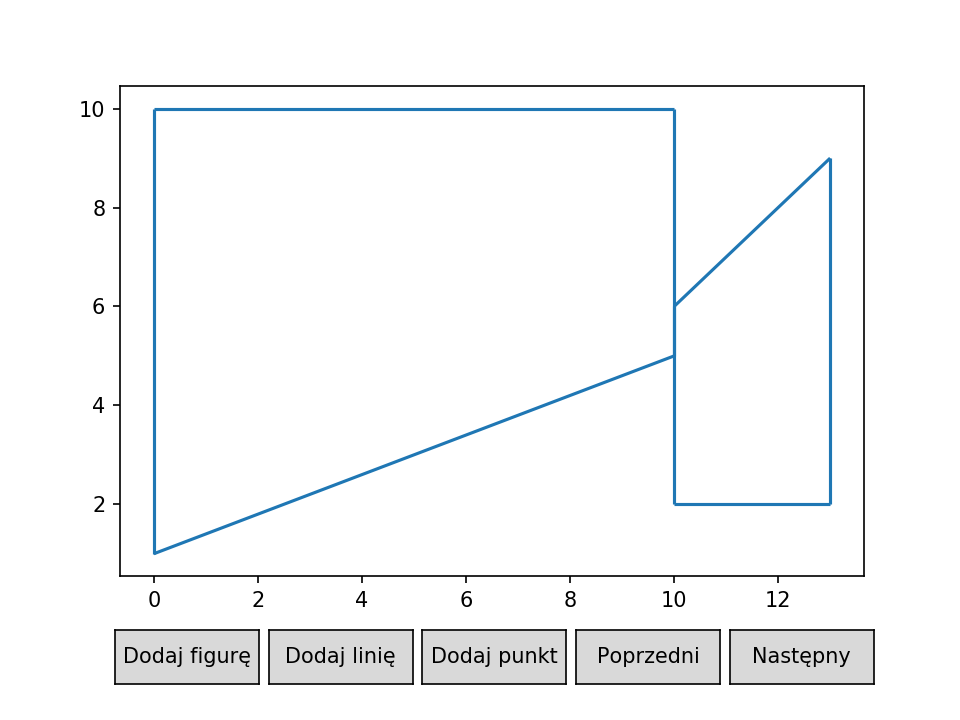

In [5]:
%matplotlib notebook
scenes = [Scene([], [LinesCollection(trapezoidal_map)])]

plot = Plot(scenes)
plot.draw()

### Funkcje pomocniczne

In [6]:
%matplotlib notebook

def prepare_data(segments):
    new_segments = []
    MAX_X = MAX_Y = 0
    MIN_X = MIN_Y = 20
    for segment in segments:
        new_segment = Segment(segment)
        new_segments.append(new_segment)
        for point in [new_segment.start, new_segment.end]:
            MIN_Y = min(MIN_Y, point.y)
            MIN_X = min(MIN_X, point.x)
            MAX_Y = max(MAX_Y, point.y)
            MAX_X = max(MAX_X, point.x)

    return new_segments, MAX_Y+1, MIN_Y-1, MAX_X+1, MIN_X-1
        

def draw_collection(elements):
    return [ element.draw() for element in elements]

# Narysuj odcinki lub wielokąty oraz punkt który ma zostać odnaleziony

<IPython.core.display.Javascript object>


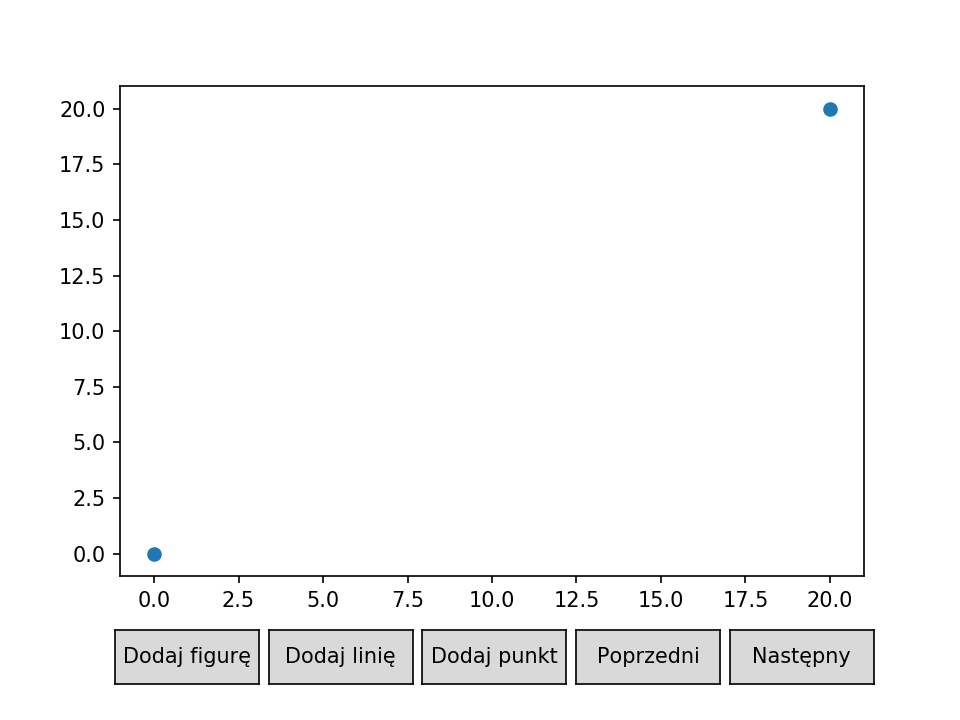

In [7]:
plot_to_draw = Plot([Scene([PointsCollection([[0,0], [20, 20]])],[])])
plot_to_draw.draw()

### Zapisywanie to do formatu json

In [8]:
%matplotlib notebook

figure_from_previous_plot = plot_to_draw.get_added_figure()
segments_from_previous_plot = plot_to_draw.get_added_lines()
points_from_previous_plot = plot_to_draw.get_added_points()
scenes = [Scene([], figure_from_previous_plot),
          Scene([], segments_from_previous_plot),
          Scene(points_from_previous_plot, []),]
with open('plot.json', 'w') as file:
    file.write(Plot(scenes).toJson())

### Odczytanie danych wejściowych z pliku json

In [9]:
%matplotlib notebook

with open('plot.json', 'r') as file:
    json = file.read()
helper_plot = Plot(json=json)
elements = helper_plot.scenes[0].lines[0].lines
lines = helper_plot.scenes[1].lines[0].lines
point_to_find = Point(helper_plot.scenes[2].points[0].points[0])
segments = elements + lines

IndexError: list index out of range

### Przygotowanie danych

In [10]:
%matplotlib notebook

new_segments, MAX_Y, MIN_Y, MAX_X, MIN_X = prepare_data(segments)

scenes = [Scene(
    [PointsCollection(draw_collection([point_to_find]), color="orange")],
    [LinesCollection(draw_collection(new_segments)),
     LinesCollection(Trapezoid(
        Point((MIN_X, MIN_Y)),
        Point((MAX_X, MAX_Y)),
        Segment([(MIN_X, MAX_Y), (MAX_X, MAX_Y)]),
        Segment([(MIN_X, MIN_Y), (MAX_X, MIN_Y)])
        ).draw(), color="green")])]
plot = Plot(scenes)
plot.draw()

NameError: name 'segments' is not defined

In [166]:
import copy

def first_segment_insertion(trapezoid, segment, res):
    end = trapezoid.rightp
    trapezoid.rightp = segment.start
    new_trapezoid1 = Trapezoid(segment.start, segment.end, trapezoid.top, segment, trapezoid, trapezoid)
    new_trapezoid2 = Trapezoid(segment.start, segment.end, segment, trapezoid.bottom, trapezoid, trapezoid)
    new_trapezoid3 = Trapezoid(segment.end, end, trapezoid.top, trapezoid.bottom, new_trapezoid1, new_trapezoid2, trapezoid.right_top, trapezoid.right_bottom)
    new_trapezoid1.right_top = new_trapezoid1.righ_bottom = new_trapezoid3
    new_trapezoid2.right_top = new_trapezoid3.righ_bottom = new_trapezoid3
    trapezoid.right_top = new_trapezoid1
    trapezoid.right_bottom = new_trapezoid2
    res.extend(trapezoid.draw())
    res.extend(new_trapezoid1.draw())
    res.extend(new_trapezoid2.draw())
    res.extend(new_trapezoid3.draw())
    

def last_elements(trapezoid, segment, orientation, prev, res):
    if prev.rightp.x == segment.end.x:
        trapezoid.leftp = segment.end
        if orientation == "bottom":
            trapezoid.left_bottom = prev
        elif orientation == "top":
            trapezoid.left_top = prev
        res.extend(trapezoid.draw())
        return
    else:    
        new_left = prev.rightp
    if orientation == "top":
        if trapezoid.leftp.y < count_y(segment, trapezoid.leftp.x):
            new_right = segment.end
            new_trapezoid = Trapezoid(new_left, new_right, trapezoid.top, segment, trapezoid.left_top, prev, trapezoid, trapezoid)
            if prev.right_top == trapezoid:
                prev.right_top = new_trapezoid
            if prev.right_bottom == trapezoid and prev.right_top != trapezoid:
                prev.right_bottom = new_trapezoid
            res.extend(new_trapezoid.draw())
            last_elements(copy.deepcopy(trapezoid), segment, orientation, new_trapezoid, res)
        else:
            if prev.rightp.x < trapezoid.leftp.x:
                new_right = trapezoid.leftp
                new_trapezoid = Trapezoid(new_left, new_right, prev.top, segment, prev, prev, trapezoid, trapezoid)
                if prev.right_top == trapezoid:
                    prev.right_top = new_trapezoid
                if prev.right_bottom == trapezoid:
                    prev.right_bottom = new_trapezoid
                res.extend(new_trapezoid.draw())
                last_elements(copy.deepcopy(trapezoid), segment, orientation, new_trapezoid, res)
                return
            else:
                new_left = trapezoid.leftp
                new_right = segment.end
                new_trapezoid = Trapezoid(new_left, new_right, trapezoid.top, segment, trapezoid.left_top, prev, trapezoid, trapezoid)
                if prev.right_top == trapezoid:
                    prev.right_top = new_trapezoid
                res.extend(new_trapezoid.draw())
                last_elements(trapezoid, segment, orientation, new_trapezoid, res)
                return
    if orientation == "bottom":
        if trapezoid.leftp.y > count_y(segment, trapezoid.leftp.x):
            new_right = segment.end
            new_trapezoid = Trapezoid(new_left, new_right, segment, trapezoid.bottom, prev, prev, trapezoid, trapezoid)
            if prev.right_top == trapezoid:
                prev.right_top = new_trapezoid
            if prev.right_bottom == trapezoid and prev.right_top != trapezoid:
                prev.right_bottom = new_trapezoid
            res.extend(new_trapezoid.draw())
            last_elements(copy.deepcopy(trapezoid), segment, orientation, new_trapezoid, res)
        else:
            if prev.rightp.x <= trapezoid.leftp.x:
                new_right = segment.end
                new_trapezoid = Trapezoid(new_left, new_right, segment, trapezoid.bottom, prev, trapezoid.left_bottom, trapezoid, trapezoid)
                if prev.right_top == trapezoid:
                    prev.right_top = new_trapezoid
                if prev.right_bottom == trapezoid and prev.right_top != trapezoid:
                    prev.right_bottom = new_trapezoid
                res.extend(new_trapezoid.draw())
                last_elements(copy.deepcopy(trapezoid), segment, orientation, new_trapezoid, res)

        

def new_segment_in_map(trapezoid, segment, res):
    if trapezoid.right_top is None and trapezoid.right_bottom is None:
        first_segment_insertion(copy.deepcopy(trapezoid), segment, res)
        return
    trapezoid.rightp = segment.start
    res.extend(trapezoid.draw())
    if count_y(trapezoid.right_top.bottom, segment.start.x) > count_y(segment, segment.start.x):
        update_map(copy.deepcopy(trapezoid.right_bottom), segment, "top", trapezoid, res)
        update_map(copy.deepcopy(trapezoid.right_bottom), segment, "bottom", trapezoid, res)
    elif count_y(trapezoid.right_bottom.top, segment.start.x) < count_y(segment, segment.start.x):
        update_map(copy.deepcopy(trapezoid.right_top), segment, "top", trapezoid, res)
        update_map(copy.deepcopy(trapezoid.right_top), segment, "bottom", trapezoid, res)
    else:
        update_map(copy.deepcopy(trapezoid.right_top), segment, "top", trapezoid, res)
        update_map(copy.deepcopy(trapezoid.right_bottom), segment, "bottom", trapezoid, res)

    
def update_map(trapezoid, segment, orientation, prev, res):
    if count_y(trapezoid.bottom, trapezoid.leftp.x)  > count_y(segment, trapezoid.leftp.x) or count_y(trapezoid.top, trapezoid.leftp.x)  < count_y(segment, trapezoid.leftp.x):
        return
    if trapezoid.rightp.x > segment.end.x and trapezoid.leftp.x < segment.start.x:
        first_segment_insertion(copy.deepcopy(trapezoid), segmen, res)
        return
    if trapezoid.rightp.x > segment.end.x:
        last_elements(copy.deepcopy(trapezoid), segment, orientation, prev, res)
        return 
    elif orientation == "top":
        if count_y(trapezoid.bottom, trapezoid.leftp.x) > count_y(segment, trapezoid.leftp.x):
            return
        if trapezoid.leftp.x > prev.rightp.x and trapezoid.leftp.y > count_y(segment, trapezoid.leftp.x):
            new_trapezoid = Trapezoid(prev.rightp, trapezoid.leftp, prev.top, segment, prev, prev, prev.right_top, trapezoid)
            update_map(copy.deepcopy(trapezoid), segment, orientation, new_trapezoid, res)
            res.extend(new_trapezoid.draw())
            return
        if trapezoid.leftp.y > count_y(segment, trapezoid.leftp.x):
            new_left = trapezoid.leftp
            if trapezoid.rightp.y > count_y(segment, trapezoid.rightp.x):
                    new_right = trapezoid.rightp
            else:
                if trapezoid.rightp.x < segment.end.x:
                    new_right = segment.end
                else:
                    new_right = trapezoid.rightp                      
        else:
            new_left = prev.rightp
            if trapezoid.rightp.y > count_y(segment, trapezoid.rightp.x):
                new_right = trapezoid.rightp 
            else:
                if count_y(trapezoid.right_bottom.top, trapezoid.rightp.x) > count_y(segment, trapezoid.rightp.x):
                    new_right = trapezoid.right_bottom.leftp
                else:
                    new_right = trapezoid.right_top.leftp    
        new_trapezoid = Trapezoid(new_left, new_right, trapezoid.top, segment, trapezoid.left_top, prev, trapezoid.right_bottom, trapezoid.right_top)
        res.extend(new_trapezoid.draw())            
        if prev.right_top == trapezoid:
            prev.right_top = new_trapezoid
        if prev.right_bottom == trapezoid and prev.right_top != trapezoid:
            if prev.rightp != segment.stert:
                prev.right_bottom = new_trapezoid
        if trapezoid.right_top.left_top == trapezoid:
            trapezoid.right_top.left_top = new_trapezoid
        if trapezoid.right_top.left_bottom == trapezoid and trapezoid.right_top.left_top != trapezoid:
            trapezoid.right_top.left_bottom = new_trapezoid
        if trapezoid.right_bottom.left_top == trapezoid:
            trapezoid.right_bottom.left_top = new_trapezoid
        update_map(copy.deepcopy(new_trapezoid.right_top), segment, orientation, new_trapezoid, res)
        update_map(copy.deepcopy(new_trapezoid.right_bottom), segment, orientation, new_trapezoid, res)
        return
    else:
        if count_y(trapezoid.top, trapezoid.leftp.x) < count_y(segment, trapezoid.leftp.x):
            return
        if trapezoid.leftp.x > prev.rightp.x:
            if trapezoid.leftp.y < count_y(segment, trapezoid.leftp.x):
                new_right = trapezoid.leftp
                new_right_bottom = trapezoid
                new_right_top = trapezoid
                new_trapezoid = Trapezoid(prev.rightp, new_right, segment, prev.bottom, prev, prev, new_right_bottom, new_right_top)
                update_map(copy.deepcopy(trapezoid), segment, orientation, new_trapezoid, res)
                res.extend(new_trapezoid.draw())
                return
            else:
                new_right = trapezoid.rightp
                new_right_bottom = trapezoid.right_bottom
                if trapezoid.right_top.leftp.y < count_y(segment, trapezoid.right_top.leftp.x):
                    new_right_top = trapezoid.right_top
                else:
                    new_right_top = trapezoid.right_bottom
                new_trapezoid = Trapezoid(prev.rightp, new_right, segment, prev.bottom, prev, prev, new_right_bottom, new_right_top)
                update_map(copy.deepcopy(new_trapezoid.right_top), segment, orientation, new_trapezoid, res)
                update_map(copy.deepcopy(new_trapezoid.right_bottom), segment, orientation, new_trapezoid, res)
                res.extend(new_trapezoid.draw())
                return      
        new_left = trapezoid.leftp         
        if trapezoid.rightp.y > count_y(segment, trapezoid.rightp.x):
            new_right = trapezoid.right_bottom.rightp
            new_right_top = trapezoid.right_bottom.right_top
            new_right_bottom = trapezoid.right_bottom.right_bottom
        else:
            new_right = trapezoid.rightp
            new_right_bottom = trapezoid.right_bottom
            if count_y(trapezoid.right_top.bottom, trapezoid.rightp.x) > count_y(trapezoid.top, trapezoid.rightp.x):
                new_right_top = trapezoid.right_bottom
            else:
                new_right_top = trapezoid.right_top
        new_trapezoid = Trapezoid(new_left, new_right, segment, trapezoid.bottom, trapezoid.left_top, trapezoid.left_bottom, new_right_bottom, new_right_top)
        res.extend(new_trapezoid.draw())      
        update_map(copy.deepcopy(new_trapezoid.right_top), segment, orientation, new_trapezoid, res)
        update_map(copy.deepcopy(new_trapezoid.right_bottom), segment, orientation, new_trapezoid, res)
        if prev.right_top == trapezoid:
            prev.right_top = new_trapezoid
        if prev.right_bottom == trapezoid and prev.right_top != trapezoid:
            if prev.rightp != segment.stert:
                prev.right_bottom = new_trapezoid
        if trapezoid.right_top.left_top == trapezoid:
            trapezoid.right_top.left_top = new_trapezoid
        if trapezoid.right_top.left_bottom == trapezoid and trapezoid.right_top.left_top != trapezoid:
            trapezoid.right_top.left_bottom = new_trapezoid
        if trapezoid.right_bottom.left_top == trapezoid:
            trapezoid.right_bottom.left_top = new_trapezoid

# Główny algorytm

In [12]:
def find_point_location(point_to_find, segments, MAX_Y, MIN_Y, MAX_X, MIN_X):
    rectangle = Trapezoid(
        Point((MIN_X, MIN_Y)),
        Point((MAX_X, MAX_Y)),
        Segment([(MIN_X, MAX_Y), (MAX_X, MAX_Y)]),
        Segment([(MIN_X, MIN_Y), (MAX_X, MIN_Y)])
        )
    starting_node = Node(WALL, rectangle)
    D = Graph(starting_node)
    for segment in segments:
        old_trapezoid = D.find(segment.start)
        new_segment_in_map(old_trapezoid, segment, [])
    return rectangle, D

## Prezentacja działania

In [13]:
%matplotlib notebook

trapezoid, D = find_point_location(point_to_find, new_segments, MAX_Y, MIN_Y, MAX_X, MIN_X)

NameError: name 'point_to_find' is not defined

## Prezentacja wyszukiwania w stworzonym grafie wyszukiwań
### Zaznacz punkt do znalezienia

In [14]:
plot_to_draw = Plot([Scene([],[LinesCollection(draw_collection(new_segments))])])
plot_to_draw.draw()

NameError: name 'new_segments' is not defined

In [15]:
%matplotlib notebook
points = plot_to_draw.get_added_points()[0]
point_to_find = Point(points.points[0])
scenes = [Scene([PointsCollection([point_to_find.draw()], color="red")],[LinesCollection(draw_collection(new_segments))])]
found_trapezoid = D.find(point_to_find, scenes, new_segments)
plot = Plot(scenes)
plot.draw()

IndexError: list index out of range

<IPython.core.display.Javascript object>


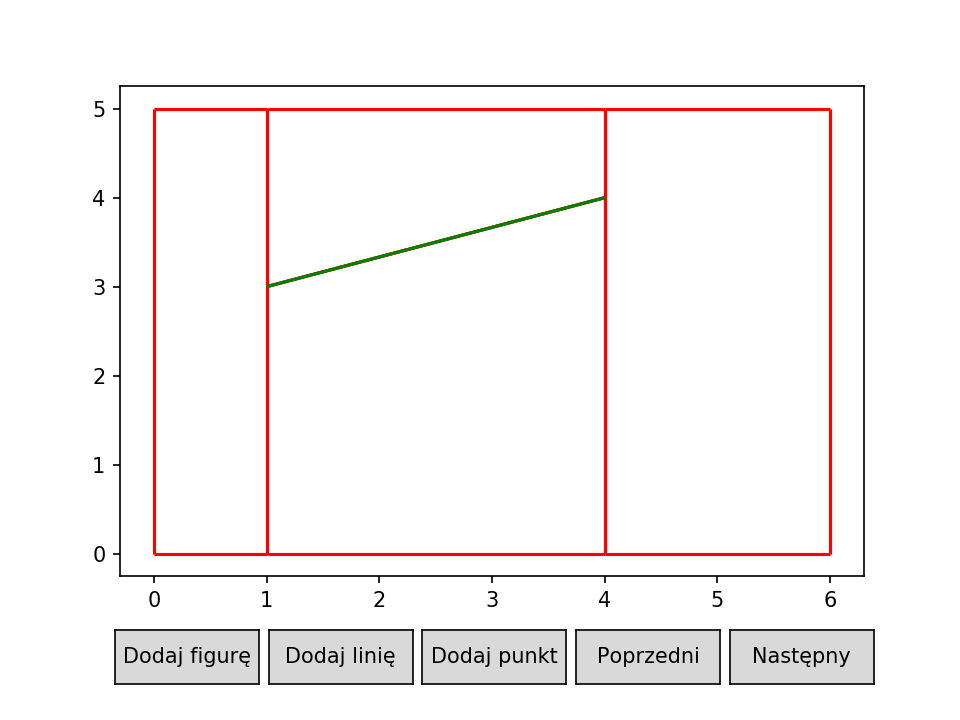

In [167]:
s1 = Segment([(1,3), (4,4)])
p1 = s1.start
q1 = s1.end
bottom = Segment([(0,0), (6,0)])
top = Segment([(0,5), (6,5)])
A = Trapezoid(bottom.start, bottom.end, top, bottom, None, None, None, None)

segments_map = [s1.draw()]
res = []
new_segment_in_map(A, s1, res)

scenes = [Scene([],
                [LinesCollection((res), color = "red"),
                 LinesCollection(segments_map, color="green")])]
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


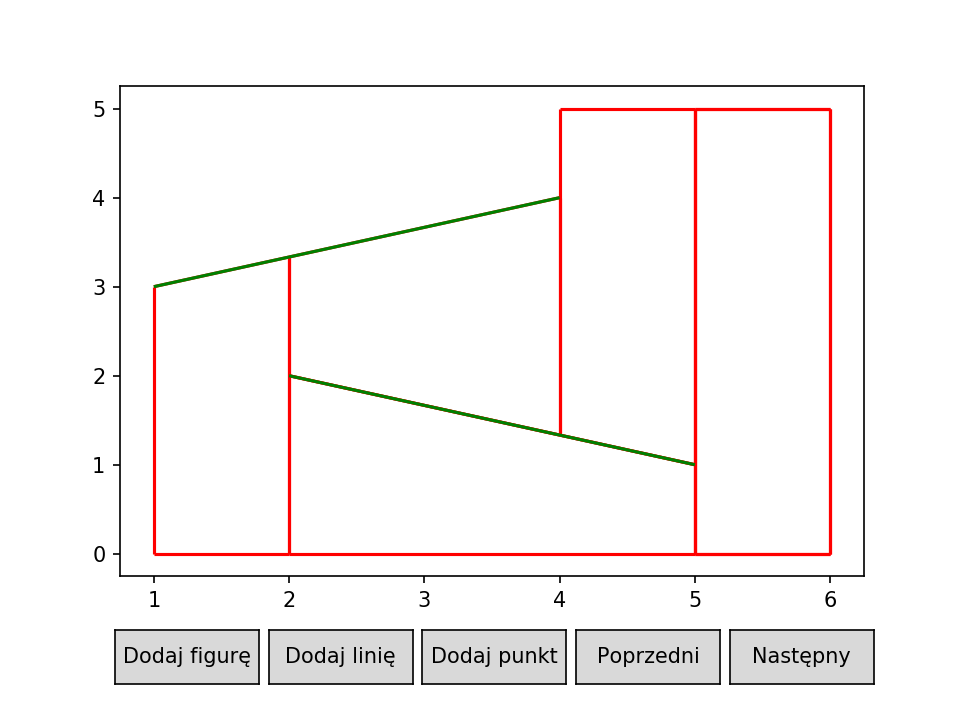

In [168]:
s1 = Segment([(1,3), (4,4)])
s2 = Segment([(2,2), (5,1)])
p1 = s1.start
q1 = s1.end
p2 = s2.start
q2 = s2.end
bottom = Segment([(0,0), (6,0)])
top = Segment([(0,5), (6,5)])
A = Trapezoid(bottom.start, p1, top, bottom)
B = Trapezoid(p1, q1, top, s1, A, A)
C = Trapezoid(p1, q1, s1, bottom, A, A)
D = Trapezoid(q1, top.end, top, bottom, B, C)
A.right_bottom = C
A.right_top = B
B.right_bottom = D
B.right_top = D
C.right_bottom = D
C.right_top = D
result = []
new_segment_in_map(C, s2, result)
# narysowanie mapy trapezowej
trapezoidal_map = []
trapezoidal_map.extend(A.draw())
trapezoidal_map.extend(B.draw())
trapezoidal_map.extend(C.draw())
trapezoidal_map.extend(D.draw())
segments_map = [s1.draw(), s2.draw()]

scenes = [Scene([],
                [#LinesCollection(trapezoidal_map),
                 LinesCollection((result), color = "red"),
                 LinesCollection(segments_map, color="green")])]
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


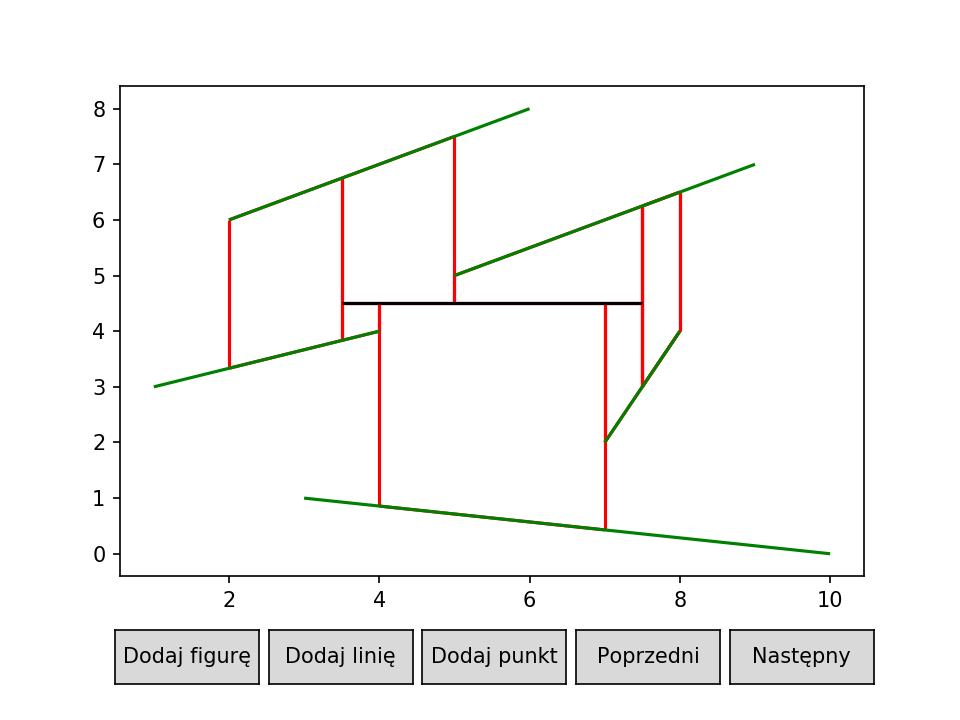

In [173]:
s1 = Segment([(2, 6), (6, 8)])
s2 = Segment([(1, 3), (4, 4)])
s3 = Segment([(3,1), (10,0)])
s4 = Segment([(7, 2), (8, 4)])
s5 = Segment([(5, 5), (9, 7)])
p1 = s1.start
q1 = s1.end
p2 = s2.start
q2 = s2.end
p3 = s3.start
q3 = s3.end
p4 = s4.start
q4 = s4.end
p5 = s5.start
q5 = s5.end
bottom = Segment([(0,0), (11,0)])
top = Segment([(0,8), (11,8)])
A = Trapezoid(bottom.start, p2, top, bottom)
B = Trapezoid(p2, p1, top, s2, A, A)
C = Trapezoid(p2, p3, s2, bottom, A, A)
D = Trapezoid(p1, q1, top, s1, B, B)
E = Trapezoid(p1, q2, s1, s2, B, B)
F = Trapezoid(p3, q3, s3, bottom, C, C)
G = Trapezoid(p3, q2, s2, s3, C, C)
H = Trapezoid(q2, p5, s1, s3, E, G)
I = Trapezoid(p5, q1, s1, s5, H, H)
J = Trapezoid(q1, q5, top, s5, I, I)
K = Trapezoid(p5, p4, s5, s3, H, H)
L = Trapezoid(p4, q4, s5, s4, K, K)
M = Trapezoid(p4, q4, s4, s3, K, K)
N = Trapezoid(q4, q5, s5, s3, L, M)
O = Trapezoid(q5, q3, top, s3, N, N)
P = Trapezoid(q5, bottom.end, top, bottom, O, O)
A.right_bottom = C
A.right_top = B
B.right_bottom = E
B.right_top = D
C.right_bottom = F
C.right_top = G
E.right_bottom = H
E.right_top = H
G.right_bottom = H
G.right_top = H
H.right_bottom = K
H.right_top = I
I.right_bottom = J
I.right_top = J
K.right_bottom = M
K.right_top = L
L.right_bottom = N
L.right_top = N
M.right_bottom = N
M.right_top = N
N.right_bottom = O
N.right_top = O
O.right_bottom = P
O.right_top = P
test1 = Segment([(4.5, 1.5), (6, 3)])
test2 = Segment([(4.5, 3), (7.5, 3.5)])
test3 = Segment([(8.5, 2), (10.5, 4.5)])
test4 = Segment([(3.5, 4.5), (7.5, 4.5)])
result = []
#new_segment_in_map(H, test1, result)
#new_segment_in_map(H, test2, result)
#new_segment_in_map(N, test3, result)
new_segment_in_map(E, test4, result)
trapezoidal_map = []
trapezoidal_map.extend(A.draw())
trapezoidal_map.extend(B.draw())
trapezoidal_map.extend(C.draw())
trapezoidal_map.extend(D.draw())
trapezoidal_map.extend(E.draw())
trapezoidal_map.extend(F.draw())
trapezoidal_map.extend(G.draw())
trapezoidal_map.extend(H.draw())
trapezoidal_map.extend(I.draw())
trapezoidal_map.extend(J.draw())
trapezoidal_map.extend(K.draw())
trapezoidal_map.extend(L.draw())
trapezoidal_map.extend(M.draw())
trapezoidal_map.extend(N.draw())
trapezoidal_map.extend(O.draw())
trapezoidal_map.extend(P.draw())
segments_map = [s1.draw(), s2.draw(), s3.draw(), s4.draw(), s5.draw()]

scenes = [Scene([],
                [#LinesCollection(trapezoidal_map),
                 LinesCollection(result, color = "red"),
                 LinesCollection(segments_map, color="green"),
                 LinesCollection([test4.draw()], color = "black")])]
plot = Plot(scenes)
plot.draw()